# Definition

Facebook is seeking experienced Machine Learning Software Engineers to join one of there ranking teams such as Search, Feed or Ads.Facebook and Kaggle have launched a machine learning engineering competition called "Identify the correct place for check ins".The Facebook Data Science team builds scalable platforms for the collection, management, and analysis of data.

Facebook has created an artificial world consisting of more than 100,000 places located in a 10 km by 10 km square. For a given set of coordinates,task is to return a ranked list of the most likely places. Data has been fabricated to resemble location signals coming from mobile devices, giving a flavor of what it takes to work with real data complicated by inaccurate and noisy values. Inconsistent and erroneous location data can disrupt experience for services like Facebook Check In.  For every user check in, we must predict a space-delimited list of the businesses they check into. we may submit up to 3 predictions for each check in.
Input data set and expected output format is located at https://www.kaggle.com/c/facebook-v-predicting-check-ins/data
I thought this can be very interesting project to work with where I can try solving real problem rather than working with toy dataset. 


Given that the data is sparse, SGDClassifier supports multi-class classification by combining multiple binary classifiers in a “one versus all” (OVA) scheme. For each of the  classes N, a binary classifier is learned that discriminates between that and all other N-1 classes. At testing time, we compute the confidence score (i.e. the signed distances to the hyperplane) for each classifier and choose the class with the highest confidence.  This is a classification prediction type problem.

There are some vauge defination of datapoint, which requires feature engineering (mainly with the time feature) + normalization of all features
Stochastic Gradient Descent is sensitive to feature scaling, so it is recommended to scale data. The major advantage of SGD is its efficiency, which is basically linear in the number of training examples. If X is a matrix of size (n, p) training has a cost of O(k n \bar p), where k is the number of iterations (epochs) and \bar p is the average number of non-zero attributes per sample.

Submissions are evaluated according to the Mean Average Precision @3  (MAP@3):

MAP@3=1|U|∑u=1|U|∑k=1min(3,n)P(k)
MAP@3=1|U|∑u=1|U|∑k=1min(3,n)P(k)
where |U| is the number of check in events,
P(k) is the precision at cutoff k, 
n is the number of predicted businesses. 

Suppose there are m missing outbound edges from a user in a social graph, and you can predict up to n other nodes that the user is likely to follow. Then, by adapting the definition of average precision in IR 
, P(k)/min(m,n) is set to zero.

(1) If the user follows recommended nodes #1 and #3 along with another node that wasn't recommend, then ap@10 = (1/1 + 2/3)/3 ≈ 0.56

(2) If the user follows recommended nodes #1 and #2 along with another node that wasn't recommend, then ap@10 = (1/1 + 2/2)/3 ≈ 0.67

(3) If the user follows recommended nodes #1 and #3 and has no other missing nodes, then ap@10 = (1/1 + 2/3)/2 ≈ 0.83

The mean average precision for N users at position n is the average of the average precision of each user, i.e.,

MAP@n=∑i=1Nap@ni/N


Note this means that order matters. But it depends. Order matters only, if there is at least one incorrect prediction. The other words, if all predictions are correct, it doesn't matter in which order they are given.

# Analysis

### Data Exploration 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

print('Loading data ...')
df_train = pd.read_csv('train.csv', dtype={'x':np.float32, 
                                               'y':np.float32, 
                                               'accuracy':np.int16,
                                              'time':np.int,
                                               'place_id':np.int}, 
                                               index_col = 0)
df_test = pd.read_csv('test.csv', dtype={'x':np.float32,
                                             'y':np.float32, 
                                             'accuracy':np.int16,
                                             'time':np.int,
                                              'place_id':np.int}, 
                                              index_col = 0)
df_sub = pd.read_csv('sample_submission.csv' ,index_col = 0) 

Loading data ...


In [3]:
print('\nSize of training data: ' + str(df_train.shape))
print('Columns:' + str(df_train.columns.values))
print('Number of places: ' + str(len(list(set(df_train['place_id'].values.tolist())))))
print('\n')

df_train.head()


Size of training data: (29118021, 5)
Columns:['x' 'y' 'accuracy' 'time' 'place_id']
Number of places: 108390




,x,y,accuracy,time,place_id
row_id,,,,,
0,0.7941,9.0809,54,470702,8523065625
1,5.9567,4.7968,13,186555,1757726713
2,8.3078,7.0407,74,322648,1137537235
3,7.3665,2.5165,65,704587,6567393236
4,4.0961,1.1307,31,472130,7440663949


A few notes:

row_id seems to be … a row ID. It is TRUE that the number of unique row_ids is the same as the number of rows in the data frame.

x is presumably bounded between [0, 10] as the x-axis on the 10-km square.

y looks to be the same as x, just the other dimension.

accuracy is intersting: it’s all over the place. The smallest value is 1.00; the biggest value is 1,033.00. We’ll have to look into that.

time has no units. Since Facebook notes that time an accuracy are "intentionally left vague in their definitions.", we will have to look into that.

place_id is probably a unique identifier. There 108390 unique values.

In [5]:
# Few statistics
stats_df_train = df_train.describe()
stats_df_train

,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,4.769263e+00,4.769553e+00,8.284912e+01,4.170104e+05,5.493787e+09
std,2.778897e+00,2.811558e+00,1.147518e+02,2.311761e+05,2.611088e+09
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,2.534700e+00,2.496700e+00,2.700000e+01,2.030570e+05,3.222911e+09
50%,5.009100e+00,4.988300e+00,6.200000e+01,4.339220e+05,5.518573e+09
75%,7.461400e+00,7.510300e+00,7.500000e+01,6.204910e+05,7.764307e+09
max,1.000000e+01,1.000000e+01,1.033000e+03,7.862390e+05,9.999932e+09


 ## Exploratory Visualization : Exploring Time

The method I used to figure out the time definition is through Fourier transform. Computing the histogram of the event time. To know the unt of time we can try to look into frequency structure of the histogram

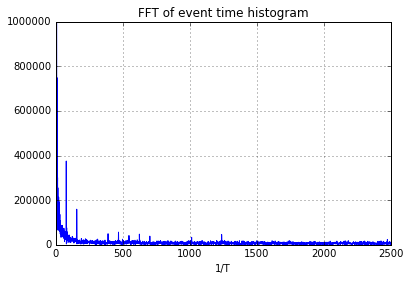

In [11]:
%matplotlib inline

time = df_train['time']
hist = hist = np.histogram(time,5000)

hist_fft = np.absolute(np.fft.fft(hist[0]))
plt.plot(hist_fft)
plt.xlim([0,2500])
plt.ylim([0,1e6])
plt.title('FFT of event time histogram')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

The peaks in the FFT curve indicate strong periodic structure at that frequency. Let's zoom-in the see the numbers.

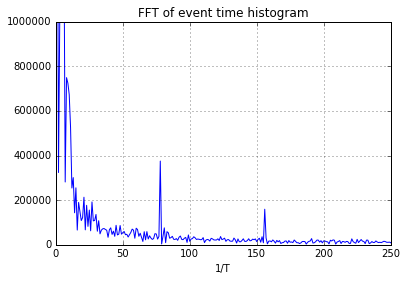

In [4]:
plt.plot(hist_fft)
plt.xlim([0,250])
plt.ylim([0,1e6])
plt.title('FFT of event time histogram')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

The first peak (fundamental frequency) is at 78 which means the time histogram has a period of: print(time.max()/78)

In [12]:
print(time.max()/78)

10079


I look at one of the most popular place_id to find more information.

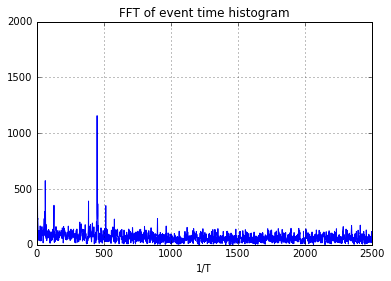

In [13]:
time = df_train[df_train['place_id']==8772469670]['time']
hist = np.histogram(time,5000)
hist_fft = np.absolute(np.fft.fft(hist[0]))

plt.plot(hist_fft)
plt.xlim([0,2500])
plt.title('FFT of event time histogram')
plt.xlabel('1/T')
plt.grid(True)
plt.show()

peaks at 64 and 451

In [17]:
T1 = time.max()/64
T2 = time.max()/451
print('period T1:', T1)
print('period T2:', T2)

('period T1:', 10151)
('period T2:', 1440)


T1 is the same period as the one found in overall histogram.
But the interesting part is that the ratio of T1 and T2 happen to be about 7, so they are very likely week and day.
And 1440 is the minute time for a day.
This result confirms that the time units are in minutes. The largest peak is at around 1440, which is the number of minutes in a day. There is another peak at around 10000, which is near the number of minutes in a week. Some other peaks can be seen too, at 5000, 1650, etc. Not sure what the significance of those are.¶


# Time and Place Analysis

In [5]:
df_placecounts = df_train["place_id"].value_counts()
# Get a list of the top 50 places for future reference
df_topplaces = df_placecounts.iloc[0:50]
l_topplaces = list(df_topplaces.index)
print(l_topplaces)

[8772469670, 1623394281, 1308450003, 4823777529, 9586338177, 9129780742, 9544215131, 5351837004, 4638096372, 8610202964, 6051554924, 7363774279, 8607353836, 8336299754, 5204012807, 7230349735, 7985287621, 4371034975, 4993591840, 7348940462, 7698408658, 5971252160, 1500208175, 8842957841, 9919909729, 9903336130, 6909189260, 1628743555, 4113278218, 3659348746, 9842669885, 2115211893, 9327149474, 4774643979, 1434514250, 1052628400, 3079940754, 2436008422, 7429036107, 7957806476, 1757105910, 3383150218, 4153795181, 5853289810, 1032449037, 5676118839, 1805113565, 9896320437, 7729330444, 1978057520]


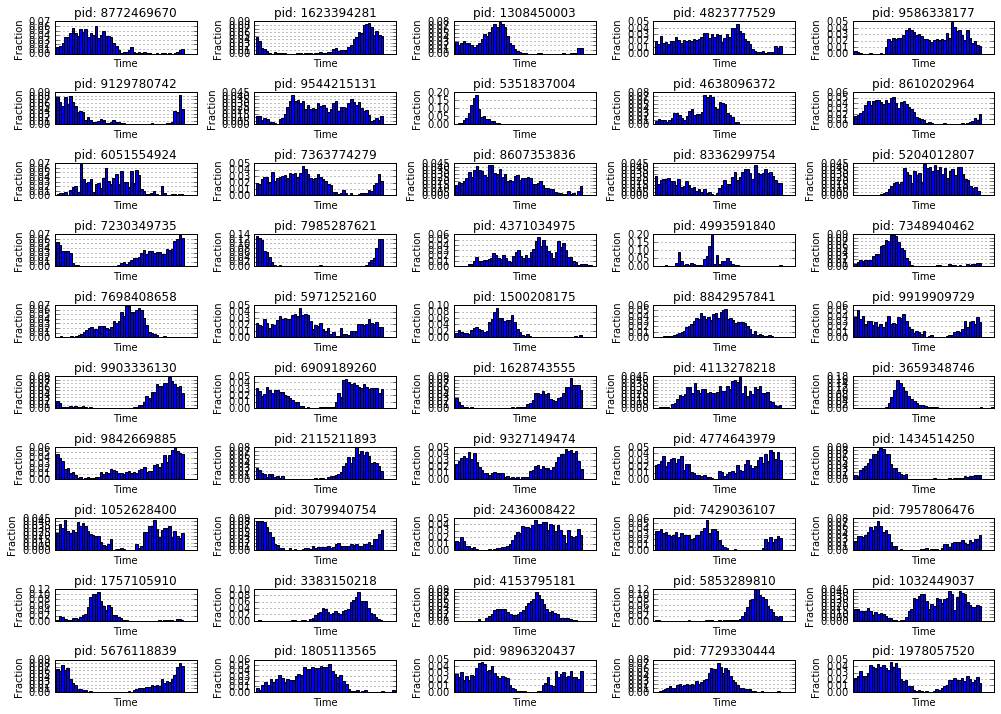

In [28]:
plt.figure(6, figsize=(14,10))
for i in range(len(l_topplaces)):
    place = l_topplaces[i]

    df_place = df_train[df_train["place_id"]==place]

    # Try % 3600*24 to see daily trend assuming it's in seconds
    # Try %   60*24 if minutes
    # Try % (60*24*7))/(60.*24) for days
    counts, bins = np.histogram(df_place["time"]%(60*24), bins=50)
    binsc = bins[:-1] + np.diff(bins)/2.
    
    plt.subplot(10,5,i+1)
    plt.bar(binsc, counts/(counts.sum()*1.0), width=np.diff(bins)[0])
    plt.grid(True)
    plt.xlabel("Time")
    plt.ylabel("Fraction")
    plt.gca().get_xaxis().set_ticks([])
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()

Minutes looks pretty promising. This means we have ~555 days in train and ~140 in test.


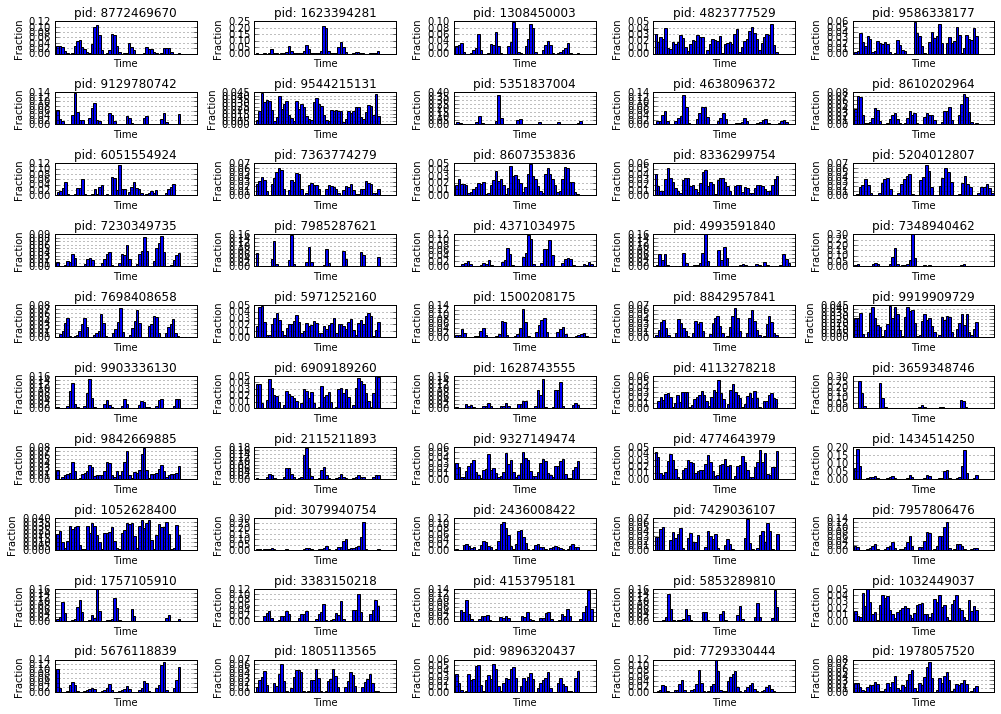

In [34]:
plt.figure(7, figsize=(14,10))
for i in range(len(l_topplaces)):
    place = l_topplaces[i]

    df_place = df_train[df_train["place_id"]==place]

    # Try % 3600*24 to see daily trend assuming it's in seconds
    # Try %   60*24 if minutes
    # Try % (60*24*7))/(60.*24) for days
    counts, bins = np.histogram(df_place["time"]%(60*24*7)/(60.*24), bins=50)
    binsc = bins[:-1] + np.diff(bins)/2.
    
    plt.subplot(10,5,i+1)
    plt.bar(binsc, counts/(counts.sum()*1.0), width=np.diff(bins)[0])
    plt.grid(True)
    plt.xlabel("Time")
    plt.ylabel("Fraction")
    plt.gca().get_xaxis().set_ticks([])
    plt.title("pid: " + str(place))
    
plt.tight_layout()
plt.show()

From this, we can look at day of week to identify trends (weekends), day (to find longer term seasonality). Adding the time dimension definitely helps. The daily cycles are clearly visible above - for certain places the check in’s stop for a few hours and then start picking up again. Other businesses have quite a few peaks throughtout the day, and the peaks tend to be rather different for different businesses.

# Location co-ordinates and PlaceID 

Lets look at top places on map

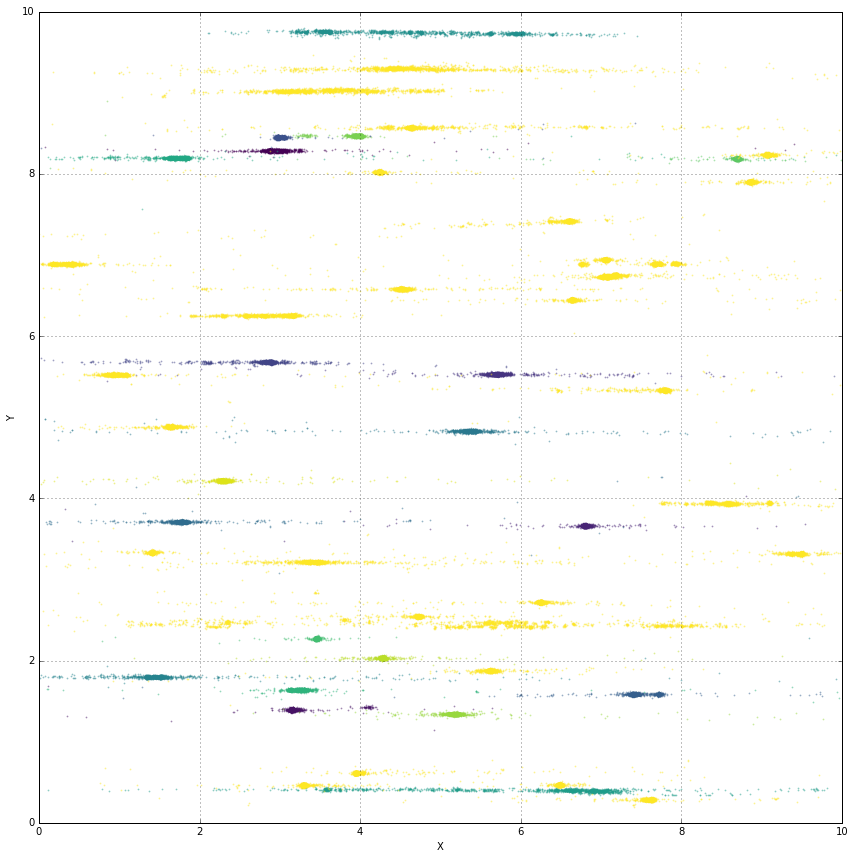

In [9]:
plt.figure(14, figsize=(12,12))

for i in range(50):
    place = l_topplaces[i]
    df_place = df_train[df_train["place_id"]==place]
    plt.scatter(df_place["x"], df_place["y"], s=3, alpha=0.5, c=plt.cm.viridis(int(i*(255/20.))), lw=0)
    
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()


This does looks like streets on the map.  Road inference!
This is interesting. In this plot, each color represents a unique business place. Individual hexagon represents last known GPS co-ordinates of users who checked into these places. As we can see from the statistics above, variance of the GPS-X and GPS-Y over all samples is nearly similar, std=2.778897e+00 for X and std=2.811558e+00 for Y. However, if we look at the distribution of user's GPS co-ordinates associated with place_id, we see that these co-ordinates are more scattered over X than Y. For some places they span the whole X range! We can infer that either the dataset (more precisely what we sampled) consist of places which are located very close to each other or the large variance is due to inaccurate GPS locations; we should check accuracies of all these points.

# Location co-ordinates and Accuracy

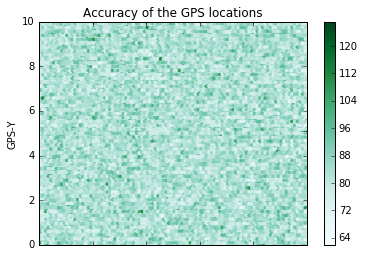

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from bokeh.plotting import figure, show, output_notebook
ax = df_train.plot(kind='hexbin', x='x', y='y', C='accuracy')
ax.set_xlabel("GPS-X")
ax.set_ylabel("GPS-Y")
ax.set_title("Accuracy of the GPS locations")

From this plot, we can observe that many of the locations have low to medium accuracies. Our data should speak the same. Let's validate this.

In [39]:
acc_min, acc_max = df_train["accuracy"].min(), df_train["accuracy"].max()
print("Locations with accuracy above average: {}%".format(
        sum(df_train["accuracy"] > (acc_max-acc_min)/2.0)*100/float(df_train.shape[0])))

Locations with accuracy above average: 1.85301741489%


Only 1.85% of the locations have acuracy above average. Let's take one of the business locations and try to visualize accuracy spread of the user's locations who visited it.

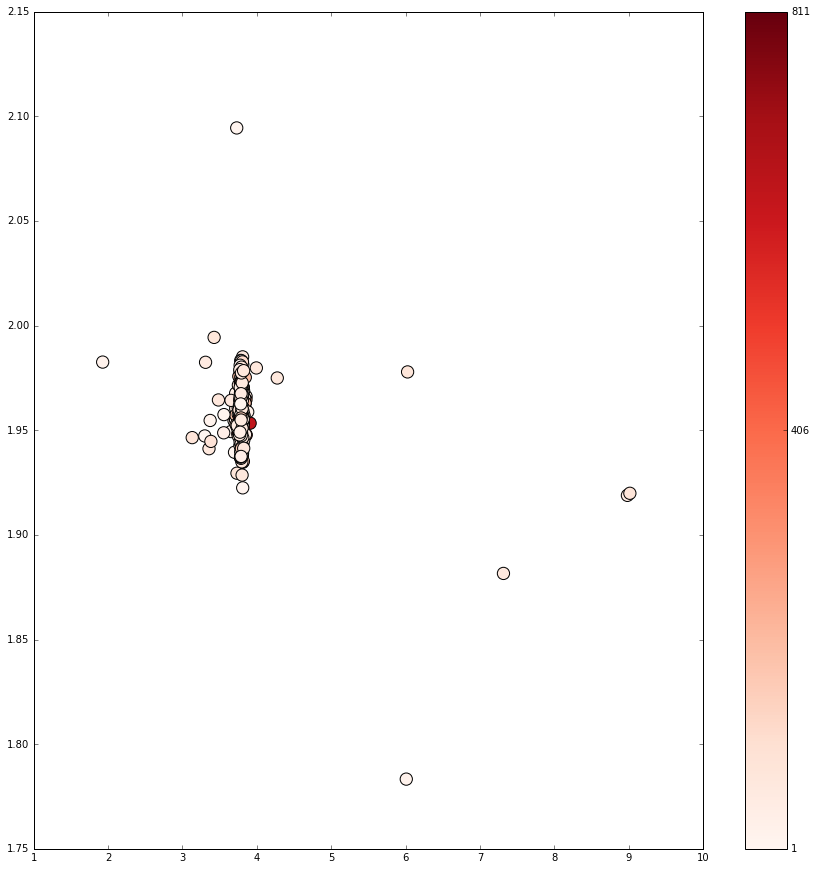

In [43]:
place_id = df_train.place_id.unique()[5]
df_place = df_train[df_train["place_id"]==place_id]

fig, ax = plt.subplots()
cax = plt.scatter(df_place["x"], df_place["y"], c=df_place["accuracy"], s=150.0, cmap=plt.cm.Reds)
cbar = fig.colorbar(cax, ticks=[df_place["accuracy"].min(), 
                        (df_place["accuracy"].max()+df_place["accuracy"].min())/2, df_place["accuracy"].max()])

At first, it might seem that locations are spread out in y. However, if we look carefully we see that the Y axis scale is very small compared to the X axis. We can find the same thing from their statistics:

In [44]:
print("X min:{}, max:{}, var:{}".format(df_place["x"].min(), df_place["x"].max(), df_place["x"].var()))
print("Y min:{}, max:{}, var:{}".format(df_place["y"].min(), df_place["y"].max(), df_place["y"].var()))

X min:1.92879998684, max:9.01469993591, var:0.159900277853
Y min:1.78330004215, max:2.09450006485, var:0.000216961212573


Clearly locations are more spread out in X, and as found earlier, sometimes they even span the whole X range. Based on these findings, we can guess that the people are mostly coming from left or right side of this mini palces map or the roads are planned in such a way.
Now, to find out the actual location of the place the easiest approach would be to take the mean value. To get more precise estimate we should take the weighted average of the locations with weights being the accuracy of the location. This way we give more importance to locations reported with high accuracy that the lower ones. Let's check the difference

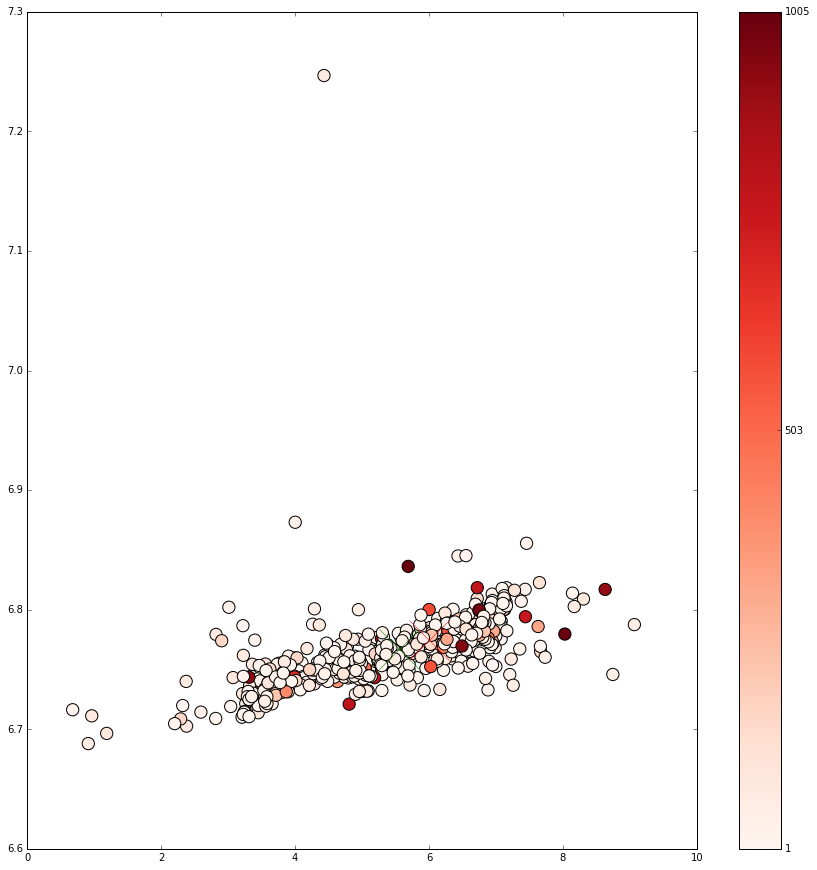

In [52]:
place_id = df_train.place_id.unique()[7]
df_place = df_train[df_train["place_id"]==place_id]

x_wt = df_place["accuracy"]*df_place["x"]
x_wt_mean = x_wt.sum()/float(sum(df_place["accuracy"]))

y_wt = df_place["accuracy"]*df_place["y"]
y_wt_mean = y_wt.sum()/float(sum(df_place["accuracy"]))

fig, ax = plt.subplots()
cax = plt.scatter(df_place["x"], df_place["y"], c=df_place["accuracy"], s=150.0, cmap=plt.cm.Reds)
cbar = fig.colorbar(cax, ticks=[df_place["accuracy"].min(), 
                        (df_place["accuracy"].max()+df_place["accuracy"].min())/2, df_place["accuracy"].max()])
plt.plot(x_wt_mean, y_wt_mean, "x", c="red", markersize=40)
plt.plot(df_place["x"].mean(), df_place["y"].mean(), "x", c="green", markersize=40)

### Analysis : Algorithms and Techniques

In this competition we’re given around 30 million (simulated) check-ins on Facebook in a 10km by 10km grid. The goal is to build a model that predicts what business a user checks into based on spatial and temporal information. The tricky part here is that there are around 100k different classes(place_id’s) so most supervised learning techniques won’t work on the entire dataset. However most classes are clustered in only certain parts of the grid so the idea I’ll pursue here is to select a small-ish square within the grid and try to see if we can do better within the small square. 

Looking at the volume of data I thought of few machine learning algorithm : Random Forest, Stochastic Gradient Descent or may be KNN.
SGD can be successfully applied to large-scale and sparse machine learning problems. Given that the data is sparse, the classifiers in this module easily scale.
The advantages of Stochastic Gradient Descent are:
Efficiency.
Ease of implementation (lots of opportunities for code tuning).
The disadvantages of Stochastic Gradient Descent include:
SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
SGD is sensitive to feature scaling.

# Methodology

The number of trees is equal to (n_estimators * num_class), here num_class is equal to the number of unique place_id values. Therefore, allowing more place_ids (decreasing parameter th) will slow down the computation (more trees are generated). All this is done inside each grid_cell, therefore intuitively increasing the number of cells in the grid would also slow down the computation. However, that should also decrease the number of samples inside each cell, so there is a trade-off between number of repetitions of xgboost (number of cells) and number of samples in each repetition (size of each cell).

For other classifiers like SGD this is basically a must if we don't want that one or few features dominate the objective function and make the classifier unable to learn from other features correctly.

I've tried knn before, but got a not so good result. 
Is there any rational on choosing the feature weights? I think the weights will influence how KNN measure the distance between the cluster center and each sample. I tried to rescale the features but have no idea what's the correct direction.

I also used "distance" instead of the default "uniform" for the weight parameter. This makes more sense as a closer checkins should weight more
If few neighbors is not good, using too many neighbors is not good either. Even with weight=distance, increasing the number of neighbors may reach a point in which the decision of the class is driven by noisy (not so close) neighbors

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier

Some feature engineering (mainly with the time feature) + normalization 
    of all features (substracting the mean and dividing by std) +  
    computation of a grid (size = n_cell_x * n_cell_y), which is included
    as a new column (grid_cell) in the dataframes
    
I haven't made the comparison (with and without those features), but my guess is that for linear classifiers like SGD those features can help, this is a way of including interaction between features in linear classifiers. On the other hand, tree based classifiers like GradientBoosting internally handle some feature interactions, so those new features might not add any extra information.

In [55]:
def prepare_data(df_train, df_test, n_cell_x, n_cell_y):
    """
    Some feature engineering (mainly with the time feature) + normalization 
    of all features (substracting the mean and dividing by std) +  
    computation of a grid (size = n_cell_x * n_cell_y), which is included
    as a new column (grid_cell) in the dataframes.
    Parameters:
    ----------    
    df_train: pandas DataFrame
              Training data
    df_test : pandas DataFrame
              Test data
    n_cell_x: int
              Number of grid cells on the x axis
    n_cell_y: int
              Number of grid cells on the y axis
    
    Returns:
    -------    
    df_train, df_test: pandas DataFrame
                       Modified training and test datasets.
    """
    print('Feature engineering...')
    print('    Computing some features from x and y ...')
    ##x, y, and accuracy remain the same
        ##New feature x/y
    eps = 0.00001  #required to avoid some divisions by zero.
    df_train['x_d_y'] = df_train.x.values / (df_train.y.values + eps) 
    df_test['x_d_y'] = df_test.x.values / (df_test.y.values + eps) 
        ##New feature x*y
    
    df_train['x_t_y'] = df_train.x.values * df_train.y.values  
    df_test['x_t_y'] = df_test.x.values * df_test.y.values
    
    print('    Creating datetime features ...')
    ##time related features (assuming the time = minutes)
    initial_date = np.datetime64('2014-01-01T01:01',   #Arbitrary decision
                                 dtype='datetime64[m]') 
        #working on df_train  
    d_times = pd.DatetimeIndex(initial_date + np.timedelta64(int(mn), 'm') 
                               for mn in df_train.time.values)    
    df_train['hour'] = d_times.hour
    df_train['weekday'] = d_times.weekday
    df_train['day'] = d_times.day
    df_train['month'] = d_times.month
    df_train['year'] = d_times.year
    df_train = df_train.drop(['time'], axis=1)
        #working on df_test    
    d_times = pd.DatetimeIndex(initial_date + np.timedelta64(int(mn), 'm') 
                               for mn in df_test.time.values)    
    df_test['hour'] = d_times.hour
    df_test['weekday'] = d_times.weekday
    df_test['day'] = d_times.day
    df_test['month'] = d_times.month
    df_test['year'] = d_times.year
    df_test = df_test.drop(['time'], axis=1)
    
    print('Computing the grid ...')
    #Creating a new colum with grid_cell id  (there will be 
    #n = (n_cell_x * n_cell_y) cells enumerated from 0 to n-1)
    size_x = 10. / n_cell_x
    size_y = 10. / n_cell_y
        #df_train
    xs = np.where(df_train.x.values < eps, 0, df_train.x.values - eps)
    ys = np.where(df_train.y.values < eps, 0, df_train.y.values - eps)
    pos_x = (xs / size_x).astype(np.int)
    pos_y = (ys / size_y).astype(np.int)
    df_train['grid_cell'] = pos_y * n_cell_x + pos_x
            #df_test
    xs = np.where(df_test.x.values < eps, 0, df_test.x.values - eps)
    ys = np.where(df_test.y.values < eps, 0, df_test.y.values - eps)
    pos_x = (xs / size_x).astype(np.int)
    pos_y = (ys / size_y).astype(np.int)
    df_test['grid_cell'] = pos_y * n_cell_x + pos_x 
    
    ##Normalization
    print('Normalizing the data: (X - mean(X)) / std(X) ...')
    cols = ['x', 'y', 'accuracy', 'x_d_y', 'x_t_y', 'hour', 
            'weekday', 'day', 'month', 'year']
    for cl in cols:
        ave = df_train[cl].mean()
        std = df_train[cl].std()
        df_train[cl] = (df_train[cl].values - ave ) / std
        df_test[cl] = (df_test[cl].values - ave ) / std
    
    return df_train, df_test

In [56]:
def process_one_cell(df_train, df_test, grid_id, th):
    """
    Does all the processing inside a single grid cell: Computes the training
    and test sets inside the cell. Fits a classifier to the training data
    and predicts on the test data. Selects the top 3 predictions.
    
    Parameters:
    ----------    
    df_train: pandas DataFrame
              Training set
    df_test: pandas DataFrame
             Test set
    grid_id: int
             The id of the grid to be analyzed
    th: int
       Threshold for place_id. Only samples with place_id with at least th
       occurrences are kept in the training set.
    
    Return:
    ------    
    pred_labels: numpy ndarray
                 Array with the prediction of the top 3 labels for each sample
    row_ids: IDs of the samples in the submission dataframe 
    """   
    #Working on df_train
    df_cell_train = df_train.loc[df_train.grid_cell == grid_id]
    place_counts = df_cell_train.place_id.value_counts()
    mask = place_counts[df_cell_train.place_id.values] >= th
    df_cell_train = df_cell_train.loc[mask.values]
    
    #Working on df_test
    df_cell_test = df_test.loc[df_test.grid_cell == grid_id]
    row_ids = df_cell_test.index
    
    le = LabelEncoder()
    y = le.fit_transform(df_cell_train.place_id.values)
    X = df_cell_train.drop(['place_id', 'grid_cell'], axis = 1).values

    #Training Classifier
    clf = SGDClassifier(loss='modified_huber', n_iter=1, random_state=0, n_jobs=-1,shuffle=True)  
    clf.fit(X, y)
    X_test = df_cell_test.drop(['grid_cell'], axis = 1).values
    y_pred = clf.predict_proba(X_test)

    pred_labels = le.inverse_transform(np.argsort(y_pred, axis=1)[:,::-1][:,:3])    
    return pred_labels, row_ids

In [57]:
def process_grid(df_train, df_test, df_sub, th, n_cells):
    """
    Iterates over all grid cells and aggregates the results of individual cells
    """    
    for g_id in range(n_cells):
        if g_id % 10 == 0:
            print('iteration: %s' %(g_id))
        
        #Applying classifier to one grid cell
        pred_labels, row_ids = process_one_cell(df_train, df_test, g_id, th)
        #Converting the prediction to the submission format
        str_labels = np.apply_along_axis(lambda x: ' '.join(x.astype(str)), 
                                         1, pred_labels)
        #Updating submission file
        df_sub.loc[row_ids] = str_labels.reshape(-1,1)
        
    return df_sub  

# Result

I filtered out samples from classes that are underrepresented (using the threshold th) inside each grid cell. As the classifier is trained with only those remaining class labels, it can only predict one of them for the test set. Therefore, if the true label of a test sample is not one of those remaining labels, the classifier will make a mistake for sure. This was done with few ideas in mind:

.- Speed-up the computation (less samples are used for training inside each grid cell), < 20 mins to run on kaggle.

.- Reduce the number of classes, classifiers tend to work poorly when there are too many classes (the problem becomes more complex).

.- In any case it is difficult to generalize from underrepresented classes (if you keep them, it might be the case that the classifier "ignores" them).

Of course, the decision of using th or not, or which is the optimal threshold value would depend on the selection of classifier, the size of the grid, etc...

In [58]:
if __name__ == '__main__':

    print('Loading data ...')
    df_train = pd.read_csv('train.csv', dtype={'x':np.float32, 
                                               'y':np.float32, 
                                               'accuracy':np.int16,
                                               'time':np.int,
                                               'place_id':np.int}, 
                                               index_col = 0)
    df_test = pd.read_csv('test.csv', dtype={'x':np.float32,
                                              'y':np.float32, 
                                              'accuracy':np.int16,
                                              'time':np.int,
                                              'place_id':np.int}, 
                                              index_col = 0)
    df_sub = pd.read_csv('sample_submission.csv', index_col = 0) 
    #Defining the size of the grid
    n_cell_x = 10
    n_cell_y = 10 
    df_train, df_test = prepare_data(df_train, df_test, n_cell_x, n_cell_y)
    #print (df_train.head())
    #print (df_test.head())
    #Solving classification problems inside each grid cell
    th = 500 #Threshold on place_id inside each cell. Only place_ids with at 
            #least th occurrences inside each grid_cell are considered. This
            #is to avoid classes with very few samples and speed-up the 
            #computation.
    
    df_submission  = process_grid(df_train, df_test, df_sub, th, 
                                  n_cell_x * n_cell_y)                                 
    #creating the submission
    print('Generating submission file ...')
    df_submission.to_csv("sub_with_suffle.csv", index=True) 

Loading data ...
Feature engineering...
    Computing some features from x and y ...
    Creating datetime features ...
Computing the grid ...
Normalizing the data: (X - mean(X)) / std(X) ...
iteration: 0
iteration: 10
iteration: 20
iteration: 30
iteration: 40
iteration: 50
iteration: 60
iteration: 70
iteration: 80
iteration: 90
Generating submission file ...


# Conclusion

My best submission is mainly based on this script. The LB score of the current state of the script LB ~0.56 
but changing the classifier, the size of the grid, and the threshold th it should be possible to get LB ~0.58